#### 0. Loading requirements

In [10]:
import pandas as pd
from scraper import *
import seaborn as sns
import matplotlib.pyplot as plt
import os

import sklearn
import shap

import interpret.glassbox

import xgboost

import datasets
import numpy as np
import scipy as sp
import torch
import transformers

#### 1. Summary Statistics and Visualizations

Getting summary statistics for metric and categorical variables.

In [10]:
# Importing csv file with the data
data = pd.read_csv("Product_Table_Electroworld.csv")

In [70]:
# Convert the 'bluetooth' column to integer type
data['bluetooth version'] = data['bluetooth version'].astype(str)

In [15]:
# Get dimension of the dataset
data.shape

(737, 61)

In [129]:
metric_variables = get_metric_variables(data)
categorical_variables = get_categorical_variables(data)
metric_variables_summary = get_metric_variables_summary(metric_variables)
categorical_variables_summary = get_categorical_variables_summary(categorical_variables)
# Correlation matrix for metric variables
correlation_matrix = metric_variables.corr()

Create one chart with statistics comparing the three retailers. Getting average price of products, number of products. Brand with number of products that is sold the most.

In [152]:
# Group by online-retailer and calculate average price and most supplied brands and colours
retailer_table = get_online_retailer_comparison_table(data)

Creating some visualizations to analyze some variables.

Bar Plots

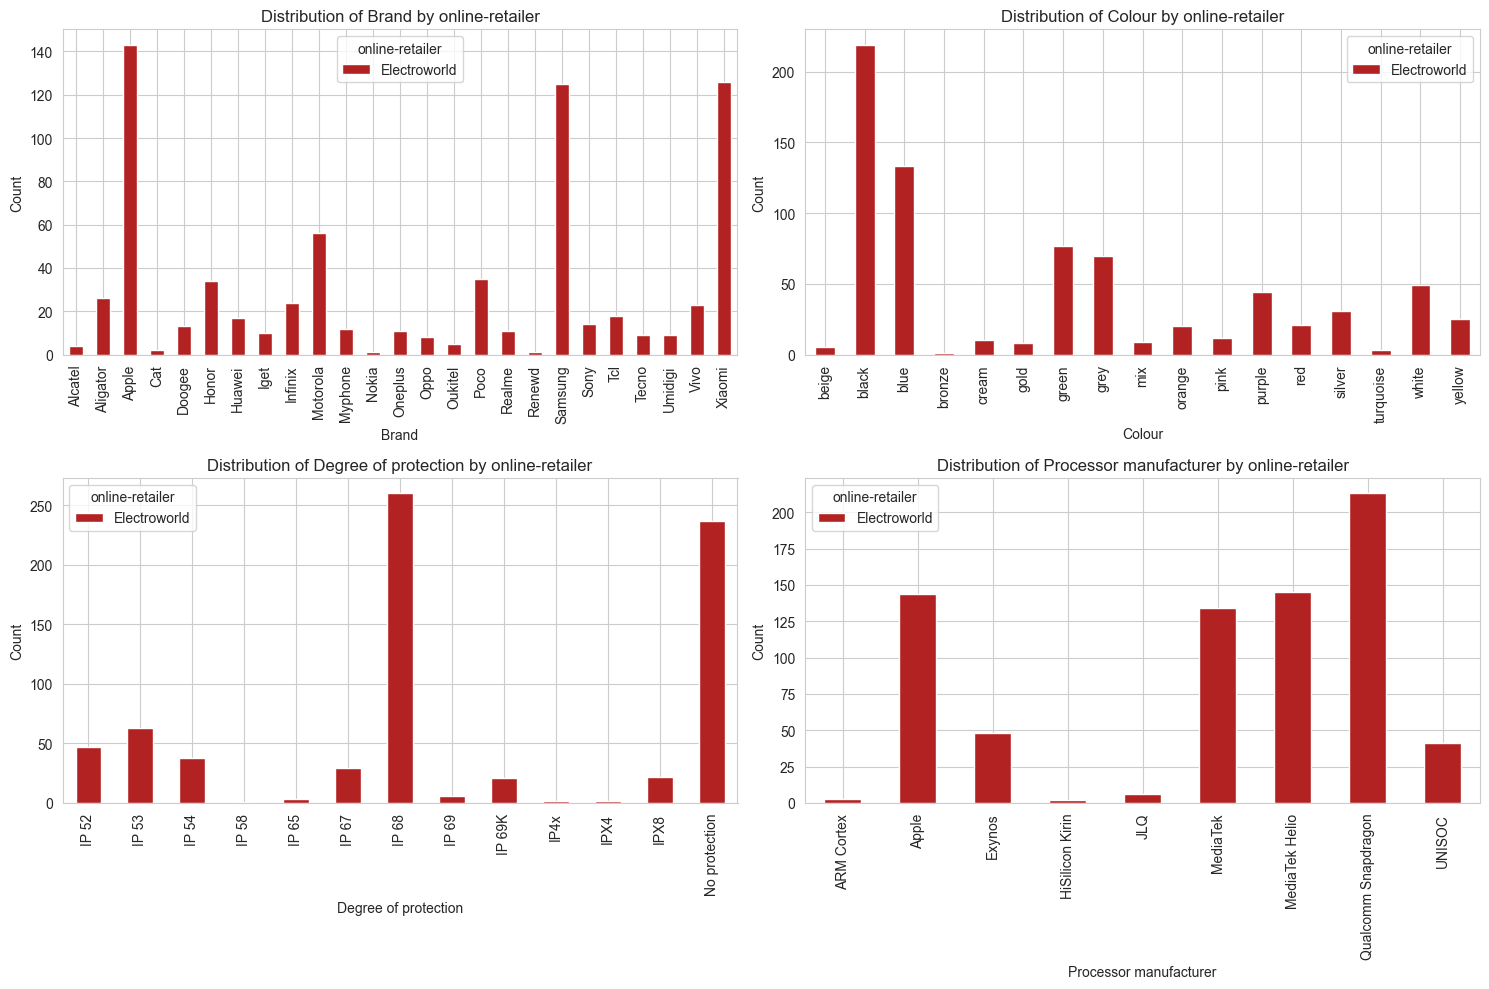

In [217]:
# List of variables to plot
variables_to_plot = ['brand', 'colour', 'degree of protection', 'processor manufacturer']
grouping_variable = 'online-retailer'  # Secondary variable for grouping

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot grouped bar chart for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx // 2, idx % 2]  # Get the current axis
    grouped_data = data.groupby([variable, grouping_variable]).size().unstack()
    grouped_data.plot(kind='bar', stacked=True, ax=ax, color = 'firebrick')
    ax.set_title(f'Distribution of {variable.capitalize()} by {grouping_variable}')
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Saving the plots in the "images" directory
# Get the current working directory
current_directory = os.getcwd()

# Create the "images" folder if it doesn't exist
images_folder = os.path.join(current_directory, "images")
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

# Save the plots in the "images" folder
plt.savefig(os.path.join(images_folder, "bar_plots_grouped.png"))

plt.show()

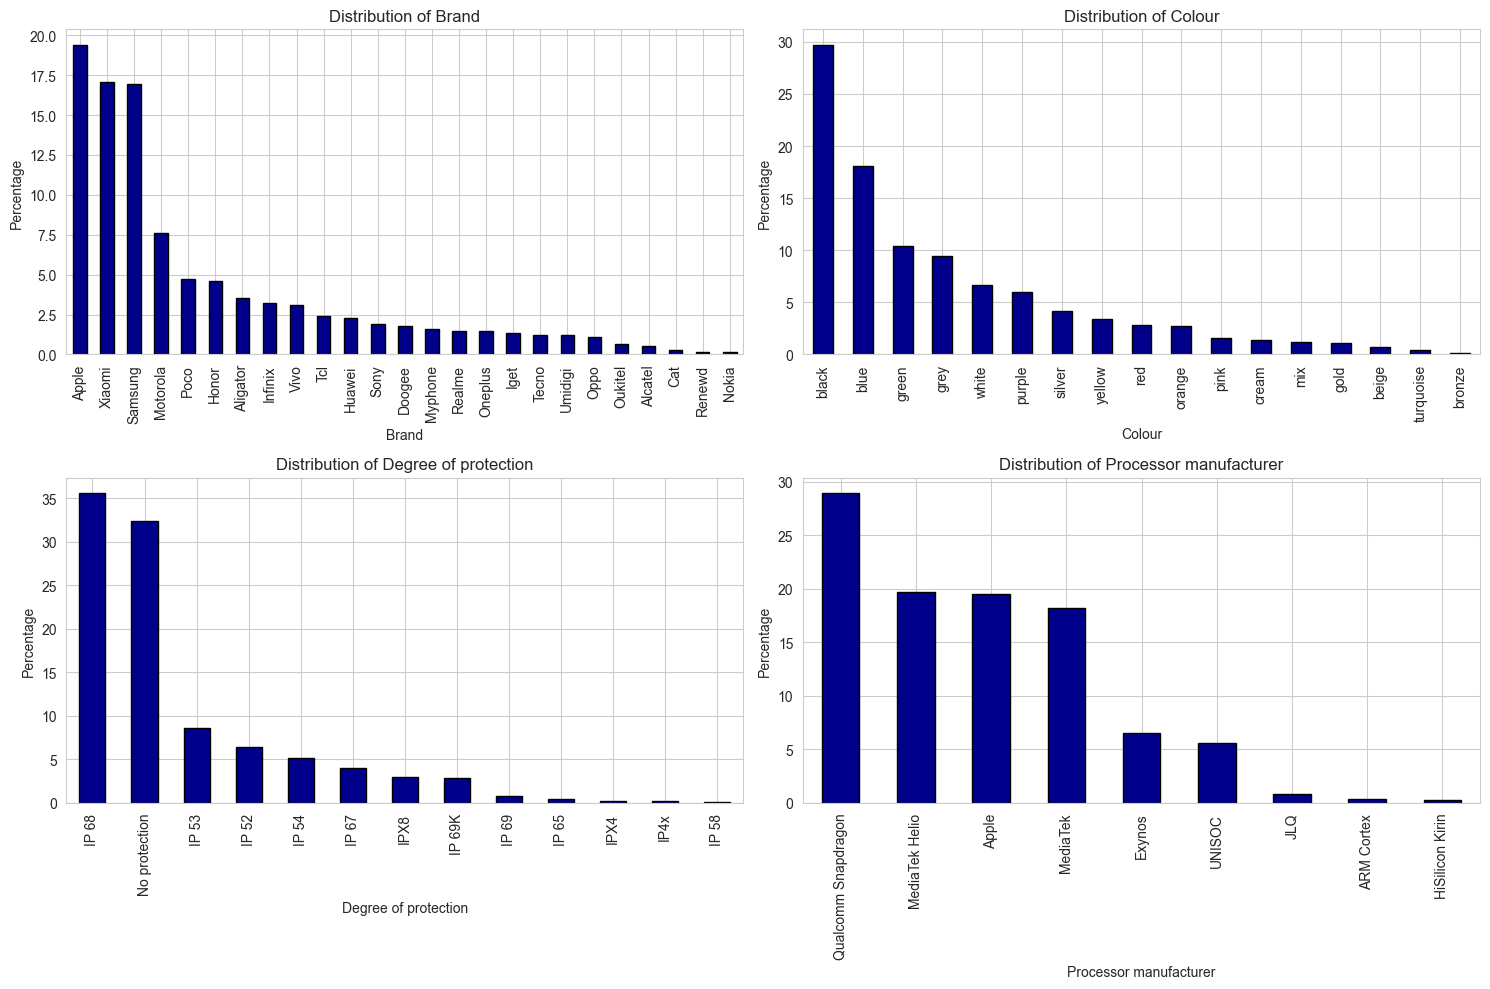

In [218]:
# List of variables to plot
variables_to_plot = ['brand', 'colour', 'degree of protection', 'processor manufacturer']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot bar chart with percentages for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx // 2, idx % 2]  # Get the current axis
    category_counts = data[variable].value_counts()
    category_percentages = (category_counts / category_counts.sum()) * 100
    category_percentages.plot(kind='bar', color='darkblue', edgecolor='black', ax=ax)
    ax.set_title(f'Distribution of {variable.capitalize()}')
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Percentage')

# Adjust layout
plt.tight_layout()

# Saving the plots in the "images" directory
# Get the current working directory
current_directory = os.getcwd()

# Create the "images" folder if it doesn't exist
images_folder = os.path.join(current_directory, "images")
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

# Save the plots in the "images" folder
plt.savefig(os.path.join(images_folder, "bar_plots.png"))

plt.show()

Pie Plots

In [179]:
display(data)

,ID,title,operating system,front cam resolution,rating,degree of protection,NFC,battery capacity,Bluetooth,bluetooth version,rear cam resolution,os brand,processor manufacturer,wireless charging performance,weight,volume,5G,online-retailer,smart,resolution label,4G/LTE,number of ratings,display size,width,internal memory,brand,FM-radio,resolution total,resolution width,processor model,WiFi standard,flash type,in-display fingerprint reader,Wi-Fi,length,colour,price,water resistant,number of front camera lenses,display fineness,resolution height,body fingerprint reader,display type,dual SIM support,depth,3.5mm jack,charging power,configuration cards,face unlock,SIM card type,connector,display refresh rate,GPS,front cam,RAM,memory card slot,fast charging,number of rear camera lenses,built-in flash,wireless charging,number of cores
0,1,Samsung Galaxy Z Fold5 512 GB modrý,Android 13,12.0,NaN,IPX8,True,4400.0,True,5.3,50.0,Android,Qualcomm Snapdragon,10,254.0,139.276786,True,Electroworld,True,Quad HD+,True,0,7.6,6.71,512,Samsung,False,3942912,2176,8 Gen 2,802.11ax,LED,False,True,15.49,blue,47999.0,True,1,376.0,1812,True,Dynamic Amoled 2X,True,1.340,False,25.0,Dual SIM + eSIM,False,nano SIM + eSIM,USB-C,120.0,True,True,12.0,False,True,3,True,True,8.0
1,2,Samsung Galaxy Z Fold5 512 GB béžový,Android 13,12.0,NaN,IPX8,True,4400.0,True,5.3,50.0,Android,Qualcomm Snapdragon,10,254.0,139.276786,True,Electroworld,True,Quad HD+,True,0,7.6,6.71,512,Samsung,False,3942912,2176,8 Gen 2,802.11ax,LED,False,True,15.49,beige,47999.0,True,1,376.0,1812,True,Dynamic Amoled 2X,True,1.340,False,25.0,Dual SIM + eSIM,False,nano SIM + eSIM,USB-C,120.0,True,True,12.0,False,True,3,True,True,8.0
2,3,Samsung Galaxy Z Fold5 512 GB černý,Android 13,12.0,NaN,IPX8,True,4400.0,True,5.3,50.0,Android,Qualcomm Snapdragon,10,254.0,139.276786,True,Electroworld,True,Quad HD+,True,0,7.6,6.71,512,Samsung,False,3942912,2176,8 Gen 2,802.11ax,LED,False,True,15.49,black,47999.0,True,1,376.0,1812,True,Dynamic Amoled 2X,True,1.340,False,25.0,Dual SIM + eSIM,False,nano SIM + eSIM,USB-C,120.0,True,True,12.0,False,True,3,True,True,8.0
3,4,Apple iPhone 15 Pro Max 1TB Black Titanium čer...,iOS 17,12.0,NaN,IP 68,True,NaN,True,5.3,48.0,iOS,Apple,15,221.0,101.180723,True,Electroworld,True,Full HD+,True,0,6.7,7.67,1000,Apple,False,3606840,2796,A17 Pro,802.11ax,True Tone,False,True,15.99,black,46490.0,True,1,460.0,1290,False,OLED,True,0.825,False,NaN,Single SIM + eSIM,True,nano SIM,USB-C,120.0,True,True,NaN,False,True,3,True,True,6.0
4,5,Apple iPhone 15 Pro Max 1TB Natural Titanium p...,iOS 17,12.0,5.0,IP 68,True,NaN,True,5.3,48.0,iOS,Apple,15,221.0,101.180723,True,Electroworld,True,Full HD+,True,1,6.7,7.67,1000,Apple,False,3606840,2796,A17 Pro,802.11ax,True Tone,False,True,15.99,grey,46490.0,True,1,460.0,1290,False,OLED,True,0.825,False,NaN,Single SIM + eSIM,True,nano SIM,USB-C,120.0,True,True,NaN,False,True,3,True,True,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,733,Aligator S6500 černý,Android 10,5.0,NaN,No protection,False,3500.0,True,4.0,13.0,Android,ARM Cortex,0,190.0,101.640000,False,Electroworld,True,HD,True,0,6.5,7.70,32,Aligator,True,648000,1200,A53,802.11n,LED,True,True,16.50,black,1198.0,False,1,202.0,540,False,IPS,True,0.800,True,5.0,"Single SIM + paměťová karta, Dual SIM",False,nano SIM,Micro USB,60.0,True,True,2.0,True,False,1,True,False,4.0
733,734,Aligator S6500 modrý,Android 10,5.0,5.0,No protection,False,3500.0,True,4.0,13.0,Android,ARM Cortex,0,190.0,101.640000,False,Electroworld,True,HD,True,1,6.5,7.70,32,Aligator,True,648000,1200,A53,802.11n,LED,True,True,16.50,blue,998.0,False,1,202.0,540,False,IPS,True,0.800,True,5.0,"Dual SIM, Single SIM + paměťová karta",False,nano SIM,Micro USB,60.0,True,True,2.0,True,False,1,True,False,4.0
734,735,Alcatel 1 2021 mobilní t

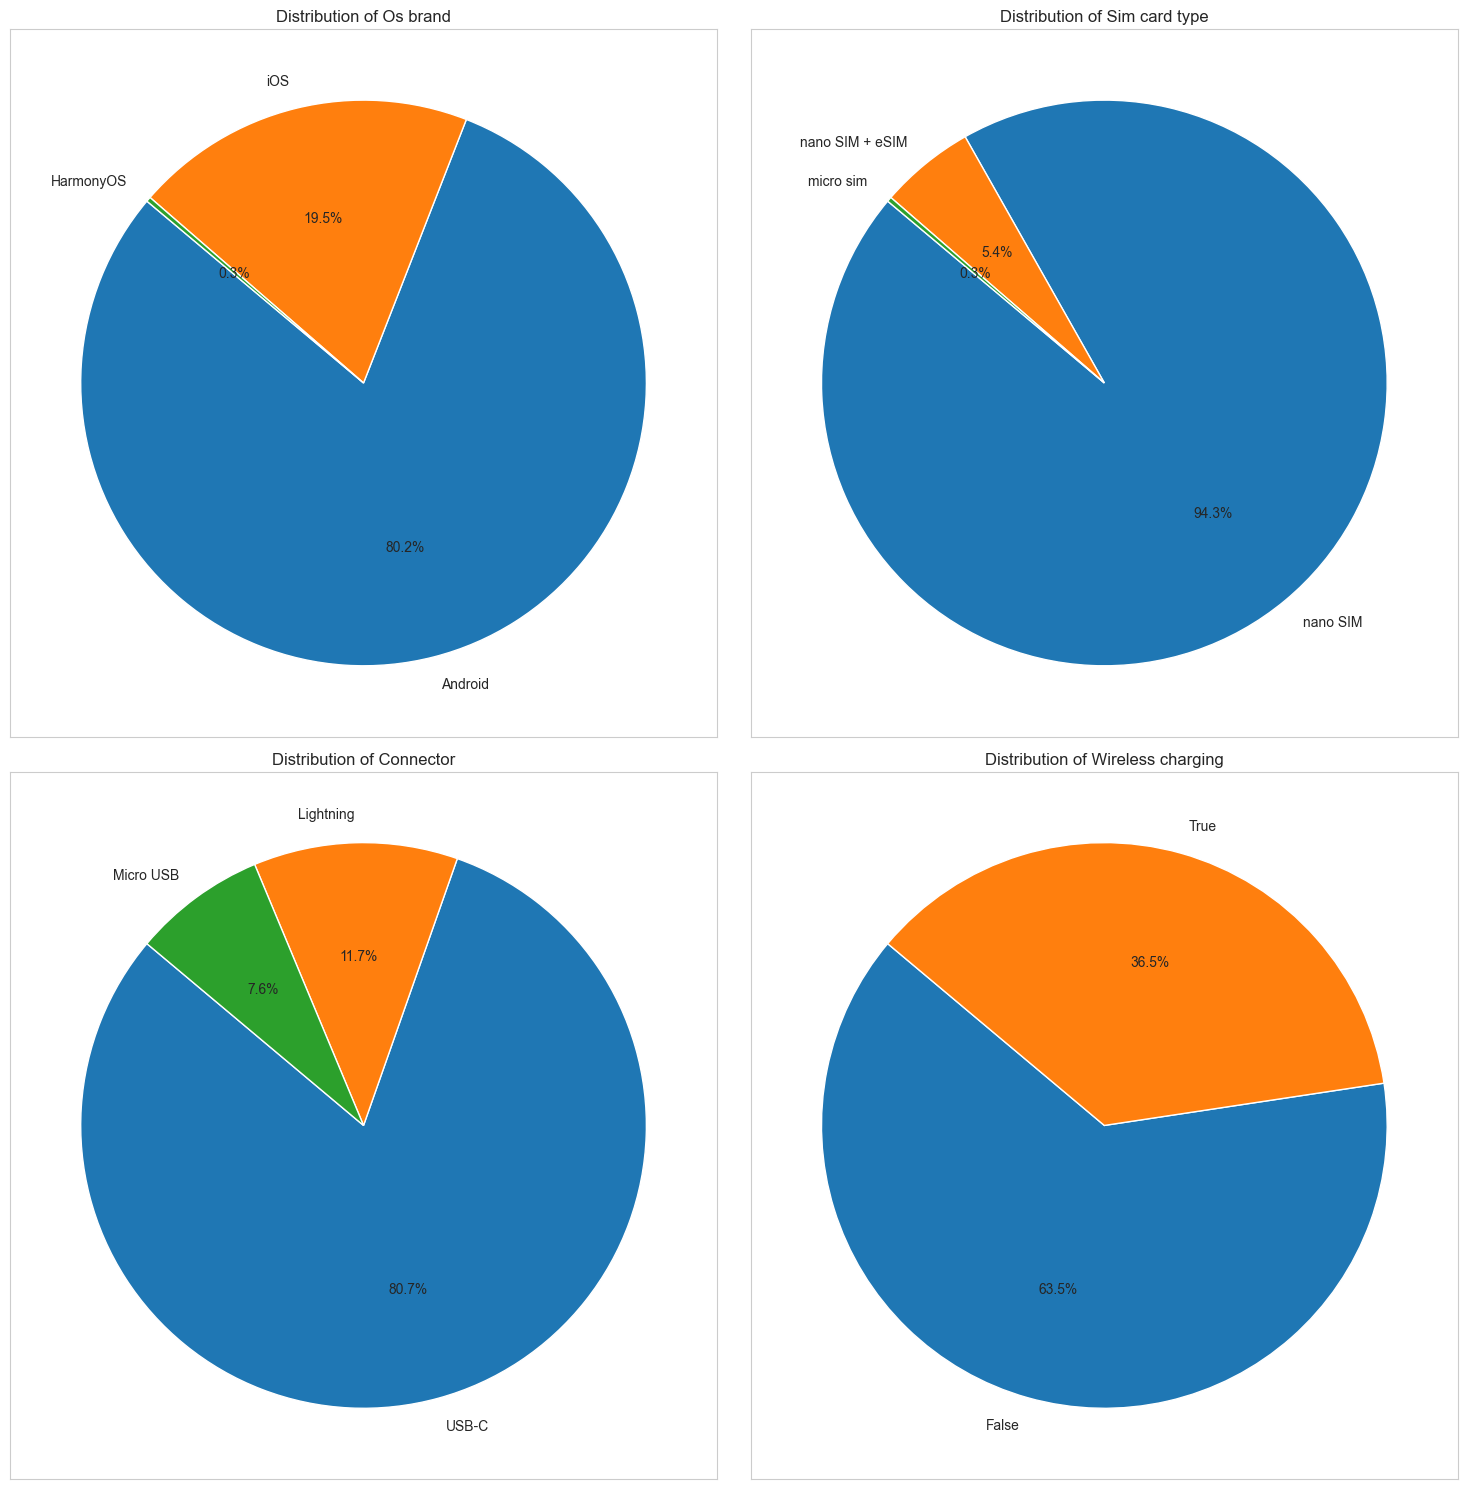

In [219]:
# List of variables to plot
variables_to_plot = ['os brand', 'SIM card type', 'connector', 'wireless charging']

# Set seaborn style and color palette
color_palette = sns.color_palette("tab10")

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot pie chart with percentages for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx // 2, idx % 2]  # Get the current axis
    category_counts = data[variable].value_counts()
    category_percentages = (category_counts / category_counts.sum()) * 100
    pie = category_percentages.plot(kind='pie', autopct='%1.1f%%', startangle=140, ax=ax, colors=color_palette)
    ax.set_title(f'Distribution of {variable.capitalize()}')
    ax.set_ylabel('')
    
    # Add frame
    ax.set_frame_on(True)

# Adjust layout
plt.tight_layout()

# Saving the plots in the "images" directory
# Get the current working directory
current_directory = os.getcwd()

# Create the "images" folder if it doesn't exist
images_folder = os.path.join(current_directory, "images")
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

# Save the plots in the "images" folder
plt.savefig(os.path.join(images_folder, "pie_plots.png"))

plt.show()

Scatterplot

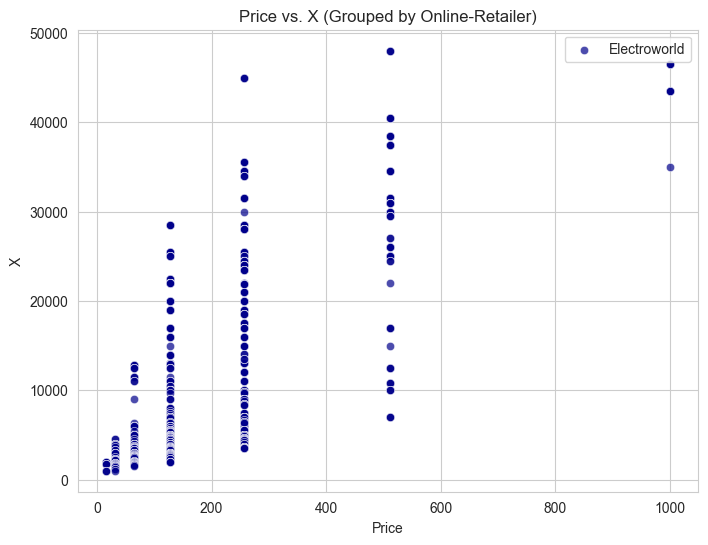

In [221]:
# Scatter plot -> front cam resolution, rear cam resolution, internal memory
# Variable comparison -> prices vs. brands (highlight retailer), prices vs. internal memory (higlight brand), brand vs. internal memory, prices vs. length (should not have positive pattern), prices vs. wireless charging
# Create subsets based on the categories
subset_Electroworld= data[data['online-retailer'] == 'Electroworld']
subset_DatArt = data[data['online-retailer'] == 'DatArt']
# Plot scatter plot with different colors for each category
plt.figure(figsize=(8, 6))
plt.scatter(subset_Electroworld['internal memory'], subset_Electroworld['price'], c='darkblue', label='Electroworld', alpha=0.7, edgecolors='w', linewidth=0.5)
#plt.scatter(subset_DatArt['rating'], subset_DatArt['price'], c='firebrick', label='DatArt', alpha=0.7, edgecolors='w', linewidth=0.5)
plt.title('Price vs. X (Grouped by Online-Retailer)')
plt.xlabel('Price')
plt.ylabel('X')#
plt.legend()
plt.grid(True)
plt.show()

Heatmap

In [ ]:
# Heatmap
# Convert data to a DataFrame
df = pd.DataFrame(data)
# Calculate the correlation matrix
correlation_matrix = df.corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Correlations between Metric Variables')
plt.show()

#### 2. Linear Regression

Questions: 
- Standardizing Data?
- taking natural log of phone prices as dependent variable?

In [ ]:
import sklearn

import shap

# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

Interpreting model coefficients

In [ ]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Partial dependence plot

In [ ]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

Calculation of SHAP Value, as difference between partial dependence plot (at the feature's values) and expected model output.

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

"The close correspondence between the classic partial dependence plot and SHAP values means that if we plot the SHAP value for a specific feature across a whole dataset we will exactly trace out a mean centered version of the partial dependence plot for that feature". Mean-centered version:

In [ ]:
shap.plots.scatter(shap_values[:, "MedInc"])

Additive Nature of SHAP values: "For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained".

Waterfall plot

In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

"The reason the partial dependence plots of linear models have such a close connection to SHAP values is because each feature in the model is handled independently of every other feature (the effects are just added together). We can keep this additive nature while relaxing the linear requirement of straight lines."

#### 3. Generalized Additive Regression Model (GAM's) - InterpretMLs explainable boosting machines

Partial dependence plot

In [ ]:
# fit a GAM model to the data
import interpret.glassbox

model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_ebm.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[sample_ind : sample_ind + 1, :],
)

Mean-centered version:

In [ ]:
shap.plots.scatter(shap_values_ebm[:, "MedInc"])

Waterfall-plot

In [ ]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind])

In [ ]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values_ebm)

#### 4. Non-additive boosted tree-model

Partial dependence plot

In [ ]:
# train XGBoost model
import xgboost

model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_xgb.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)

Mean-centered:

In [ ]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"])

Highlighting shap-values

In [ ]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"], color=shap_values)

#### 5. Linear logistic regression model

In [ ]:
# a classic adult census dataset price dataset
X_adult, y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)


def model_adult_proba(x):
    return model_adult.predict_proba(x)[:, 1]


def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:, 1] - p[:, 0]

Partial dependence plot

In [ ]:
# make a standard partial dependence plot
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "Capital Gain",
    model_adult_proba,
    X_adult,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,

If we use SHAP to explain the probability of a linear logistic regression model we see strong interaction effects. This is because a linear logistic regression model is NOT additive in the probability space. If we instead explain the log-odds output of the model we see a perfect linear relationship between the models inputs and the model’s outputs

In [ ]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])
Permutation explainer: 1001it [00:58, 14.39it/s]
shap.plots.scatter(shap_values_adult[:, "Age"])

In [ ]:
# compute the SHAP values for the linear model
explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])
Permutation explainer: 1001it [01:01, 13.61it/s]
shap.plots.scatter(shap_values_adult_log_odds[:, "Age"])

In [ ]:
# make a standard partial dependence plot
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "Age",
    model_adult_log_odds,
    X_adult,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

#### 6. Non-additive boosted tree-regression model

In [ ]:
# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(
    X_adult, y_adult * 1, eval_metric="logloss"
)

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values

By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

In [ ]:
shap.plots.bar(shap_values)

If we are willing to deal with a bit more complexity, we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

In [ ]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

In [ ]:
shap.plots.heatmap(shap_values[:1000])

In [ ]:
shap.plots.scatter(shap_values[:, "Age"])

In [ ]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

In [ ]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:, "Capital Gain"])

In [ ]:
shap.plots.scatter(shap_values[:, "Relationship"], color=shap_values)

#### 6. Dealing with correlated features

In [ ]:
clustering = shap.utils.hclust(X_adult, y_adult)

In [ ]:
shap.plots.bar(shap_values, clustering=clustering)

In [ ]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)

In [ ]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)

#### 7. Explaining a transformers NLP model

In [ ]:
import datasets
import numpy as np
import scipy as sp
import torch
import transformers

# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).cuda()


# define a prediction function
def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=500, truncation=True)
            for v in x
        ]
    ).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])  # use one vs rest logit units
    return val


# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
imdb_train = datasets.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10], fixed_context=1, batch_size=2)

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))